# Proyecto Final – Predicción de precios de casas con Deep Learning  
**CC3092 – Deep Learning**

**Universidad del Valle de Guatemala**  
**Integrantes:**  
- Andy Fuentes – 22944  
- Diederich Solís – 22952  
- Davis Roldán – 22672  

En este notebook se desarrolla un flujo completo para el problema  
**House Prices — Advanced Regression Techniques** de Kaggle, combinando técnicas de *Deep Learning* y modelos basados en árboles para datos tabulares.

Las etapas principales son:

1. Análisis exploratorio de datos (EDA).  
2. Preprocesamiento de variables numéricas y categóricas.  
3. Modelo base de XGBoost.  
4. Búsqueda de hiperparámetros para XGBoost.  
5. Entrenamiento final y generación de *submission* para Kaggle.  
6. Entrenamiento de una red neuronal mixta (features numéricas + embeddings categóricos).  
7. Comparación de resultados, discusión y conclusiones finales.


In [31]:
# 1. Introducción y carga de librerías

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

plt.style.use("seaborn-v0_8")
sns.set_theme()

# Comprobar archivos disponibles en el input de Kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## 2. Carga de datos y vista general

En esta sección se cargan los datasets de entrenamiento y prueba, 
y se revisan sus dimensiones, tipos de datos y primeras filas.

In [32]:
# Rutas de los archivos
train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"
sample_path = "/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv"

# Carga de datos
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

print("Dimensiones:")
print(f"  • train: {train.shape}")
print(f"  • test : {test.shape}")

print("\nPrimeras filas de train:")
display(train.head())

print("\nInformación general de train:")
print(train.info())

print("\nEstadísticas descriptivas de variables numéricas (train):")
display(train.describe().T)

print("\nPrimeras filas del dataset de prueba:")
display(test.head())

Dimensiones:
  • train: (1460, 81)
  • test : (1459, 80)

Primeras filas de train:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Información general de train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 n

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0



Primeras filas del dataset de prueba:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 3. Análisis exploratorio de la variable objetivo (SalePrice)

Se analiza la distribución de la variable objetivo, se aplica una transformación
logarítmica (`log1p`) y se revisa la normalidad mediante Q-Q plots, así como
estadísticos descriptivos relevantes.

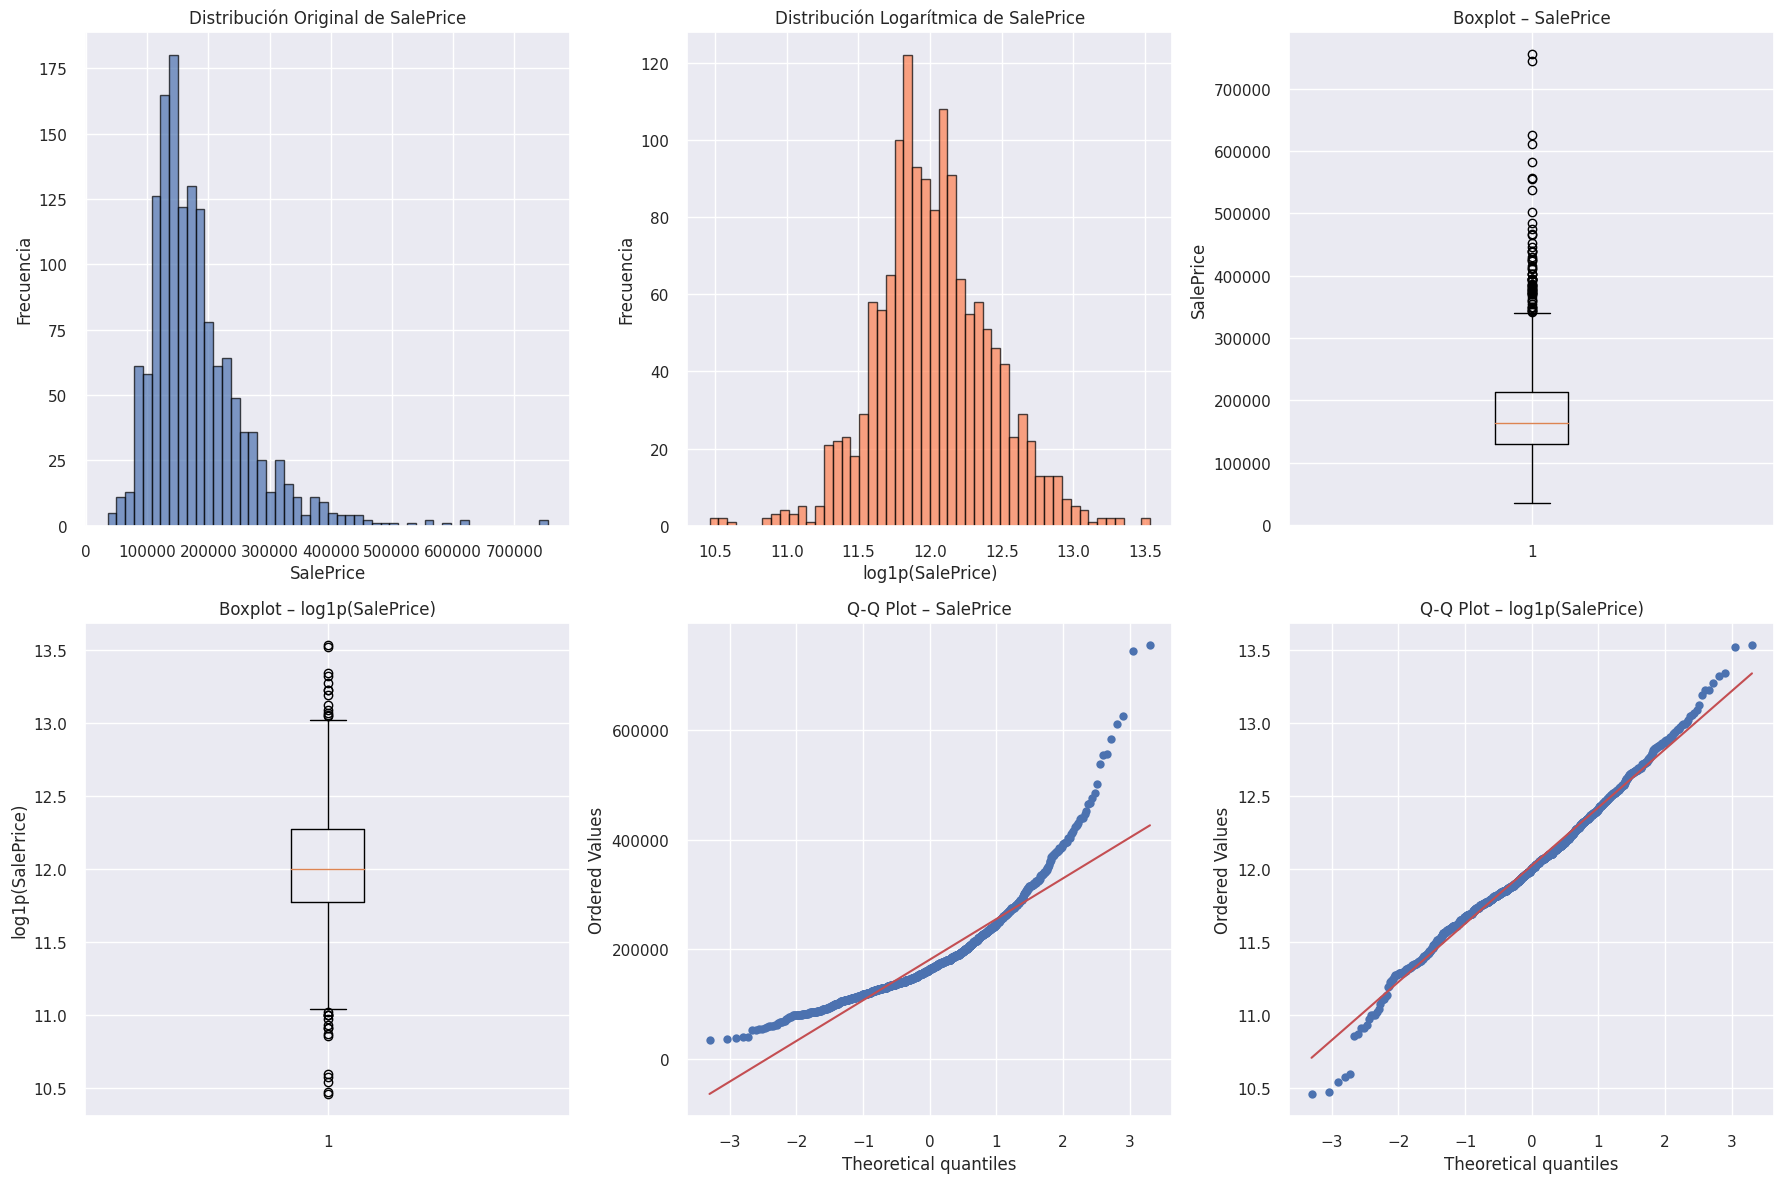

ESTADÍSTICAS DETALLADAS DE SalePrice:


,Métrica,Valor
0,Media,"$180,921.20"
1,Mediana,"$163,000.00"
2,Desviación Estándar,"$79,442.50"
3,Mínimo,"$34,900.00"
4,Máximo,"$755,000.00"
5,Asimetría (Skewness),1.8829
6,Asimetría (Log),0.1213



Insight: la transformación logarítmica reduce la asimetría de 1.88 a 0.12.


In [33]:
# Variable objetivo
target = "SalePrice"
saleprice = train[target].copy()
saleprice_log = np.log1p(saleprice)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución original
axes[0, 0].hist(saleprice, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución Original de SalePrice')
axes[0, 0].set_xlabel('SalePrice')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución logarítmica
axes[0, 1].hist(saleprice_log, bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[0, 1].set_title('Distribución Logarítmica de SalePrice')
axes[0, 1].set_xlabel('log1p(SalePrice)')
axes[0, 1].set_ylabel('Frecuencia')

# Boxplot original
axes[0, 2].boxplot(saleprice, vert=True)
axes[0, 2].set_title('Boxplot – SalePrice')
axes[0, 2].set_ylabel('SalePrice')

# Boxplot log
axes[1, 0].boxplot(saleprice_log, vert=True)
axes[1, 0].set_title('Boxplot – log1p(SalePrice)')
axes[1, 0].set_ylabel('log1p(SalePrice)')

# QQ plots
stats.probplot(saleprice, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot – SalePrice')

stats.probplot(saleprice_log, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot – log1p(SalePrice)')

plt.tight_layout()
plt.show()

# Estadísticas detalladas
stats_df = pd.DataFrame({
    'Métrica': [
        'Media', 'Mediana', 'Desviación Estándar', 
        'Mínimo', 'Máximo', 'Asimetría (Skewness)', 'Asimetría (Log)'
    ],
    'Valor': [
        f"${saleprice.mean():,.2f}",
        f"${saleprice.median():,.2f}",
        f"${saleprice.std():,.2f}",
        f"${saleprice.min():,.2f}",
        f"${saleprice.max():,.2f}",
        f"{saleprice.skew():.4f}",
        f"{saleprice_log.skew():.4f}",
    ]
})
print("ESTADÍSTICAS DETALLADAS DE SalePrice:")
display(stats_df)

print(f"\nInsight: la transformación logarítmica reduce la asimetría de "
      f"{saleprice.skew():.2f} a {saleprice_log.skew():.2f}.")

## 4. Análisis de variables numéricas

En esta sección se identifican las variables numéricas, se calcula la correlación
con la variable objetivo y se visualizan las variables más relacionadas con el precio.

Total de variables numéricas (sin incluir SalePrice): 36

TOP 15 VARIABLES NUMÉRICAS MÁS CORRELACIONADAS CON SalePrice:
 1. OverallQual          : 0.7910
 2. GrLivArea            : 0.7086
 3. GarageCars           : 0.6404
 4. GarageArea           : 0.6234
 5. TotalBsmtSF          : 0.6136
 6. 1stFlrSF             : 0.6059
 7. FullBath             : 0.5607
 8. TotRmsAbvGrd         : 0.5337
 9. YearBuilt            : 0.5229
10. YearRemodAdd         : 0.5071
11. GarageYrBlt          : 0.4864
12. MasVnrArea           : 0.4775
13. Fireplaces           : 0.4669
14. BsmtFinSF1           : 0.3864
15. LotFrontage          : 0.3518


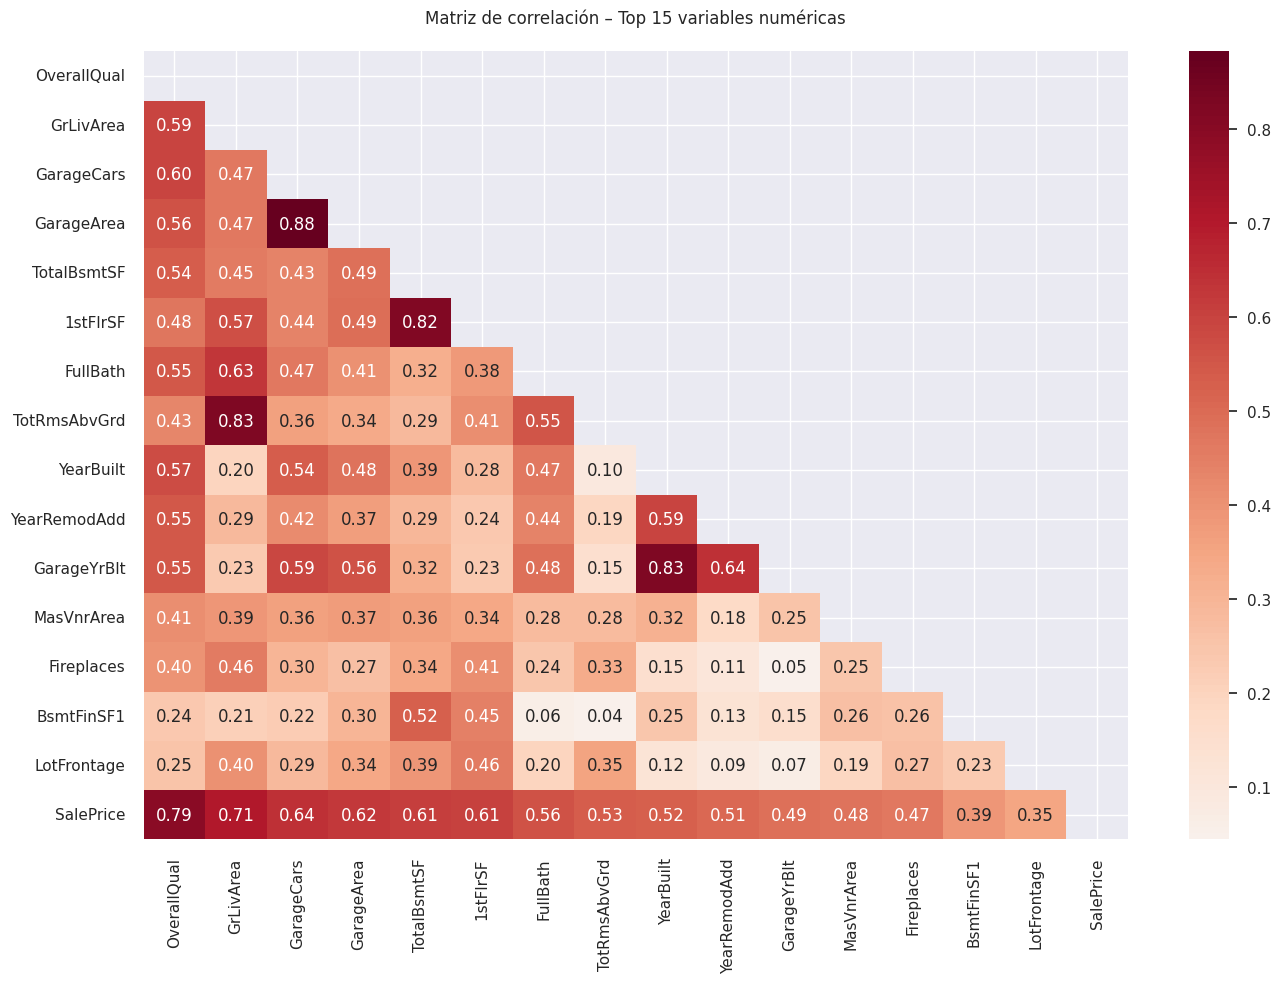

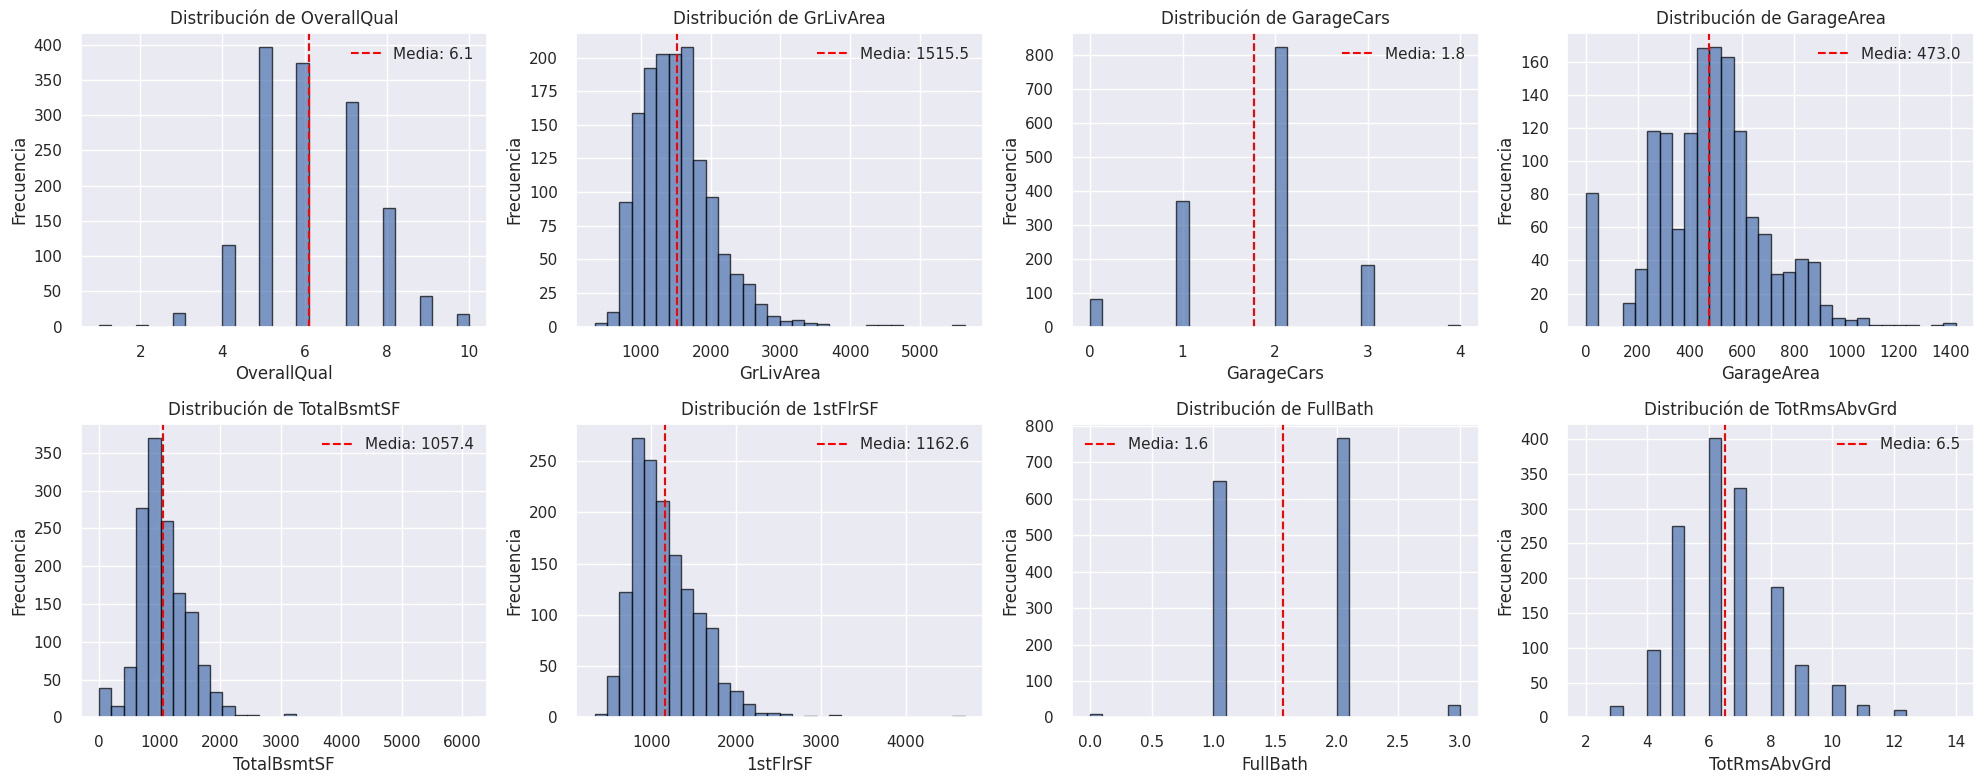

In [34]:
# Identificar variables numéricas
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Remover SalePrice y Id de esta lista
if "SalePrice" in numeric_cols:
    numeric_cols.remove("SalePrice")
if "Id" in numeric_cols:
    numeric_cols.remove("Id")

print(f"Total de variables numéricas (sin incluir SalePrice): {len(numeric_cols)}")

# Correlación con la variable objetivo
corr_with_target = train[numeric_cols + [target]].corr()[target].sort_values(ascending=False)
top_15 = corr_with_target[1:16].index.tolist()  # excluimos SalePrice mismo

print("\nTOP 15 VARIABLES NUMÉRICAS MÁS CORRELACIONADAS CON SalePrice:")
for i, col in enumerate(top_15, 1):
    print(f"{i:2d}. {col:20} : {corr_with_target[col]:.4f}")

# Heatmap de correlación de las top 15
plt.figure(figsize=(14, 10))
corr_matrix_top = train[top_15 + [target]].corr()
mask = np.triu(np.ones_like(corr_matrix_top, dtype=bool))
sns.heatmap(corr_matrix_top, annot=True, fmt=".2f", cmap="RdBu_r", center=0, mask=mask)
plt.title("Matriz de correlación – Top 15 variables numéricas", pad=20)
plt.tight_layout()
plt.show()

# Distribuciones de algunas variables clave
key_numeric = top_15[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.ravel()

for i, col in enumerate(key_numeric):
    axes[i].hist(train[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    mean_val = train[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f"Media: {mean_val:.1f}")
    axes[i].legend()

plt.tight_layout()
plt.show()

## 5. Análisis de variables categóricas

En esta sección se identifican las variables categóricas, se analiza su cardinalidad
y se estudia el impacto de algunas de ellas sobre el precio promedio de venta.

Total de variables categóricas: 43

CARDINALIDAD DE VARIABLES CATEGÓRICAS (Top 10):


,Variable,Categorias_Unicas
8,Neighborhood,25
16,Exterior2nd,16
15,Exterior1st,15
41,SaleType,9
9,Condition1,9
10,Condition2,8
12,HouseStyle,8
14,RoofMatl,8
31,Functional,7
25,BsmtFinType2,6


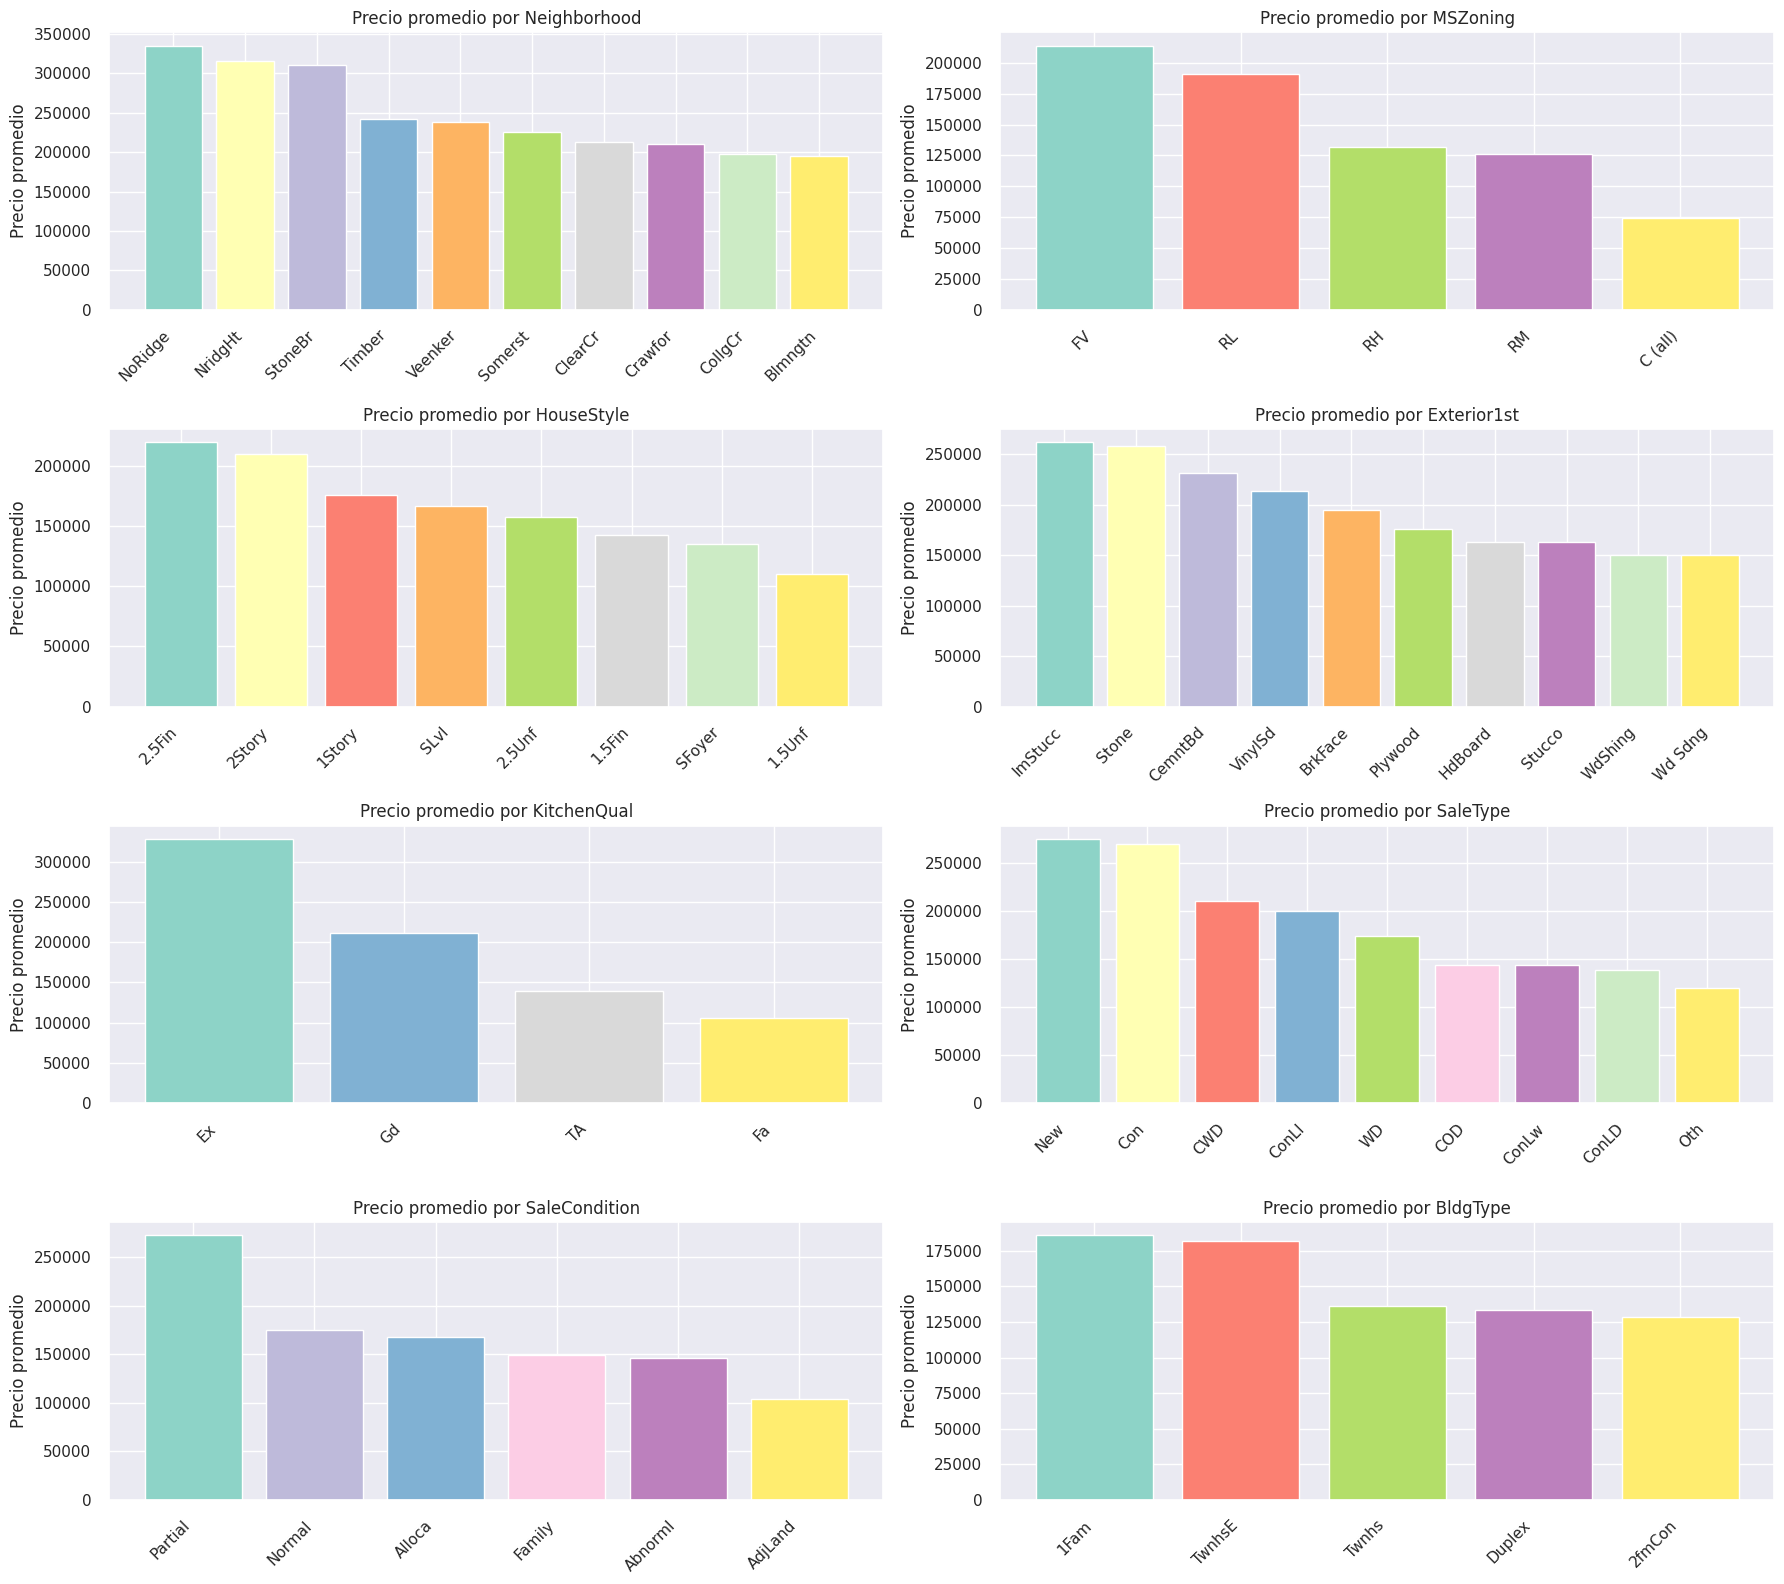

In [35]:
# Variables categóricas
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
print(f"Total de variables categóricas: {len(categorical_cols)}")

# Cardinalidad
cardinality = {
    col: train[col].nunique() for col in categorical_cols
}
cardinality_df = (
    pd.DataFrame(list(cardinality.items()), columns=["Variable", "Categorias_Unicas"])
    .sort_values("Categorias_Unicas", ascending=False)
)

print("\nCARDINALIDAD DE VARIABLES CATEGÓRICAS (Top 10):")
display(cardinality_df.head(10))

# Algunas variables categóricas clave
key_cat = [
    "Neighborhood", "MSZoning", "HouseStyle", "Exterior1st",
    "KitchenQual", "SaleType", "SaleCondition", "BldgType"
]

fig, axes = plt.subplots(4, 2, figsize=(18, 16))
axes = axes.ravel()

for i, col in enumerate(key_cat):
    if col in train.columns:
        group_stats = (
            train.groupby(col)[target]
            .agg(["mean", "count"])
            .sort_values("mean", ascending=False)
        )
        # limitar a 10 categorías si hay muchas
        if len(group_stats) > 10:
            group_stats = group_stats.head(10)

        axes[i].bar(
            range(len(group_stats)),
            group_stats["mean"],
            color=plt.cm.Set3(np.linspace(0, 1, len(group_stats)))
        )
        axes[i].set_title(f"Precio promedio por {col}")
        axes[i].set_ylabel("Precio promedio")
        axes[i].set_xticks(range(len(group_stats)))
        axes[i].set_xticklabels(group_stats.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

## 6. Análisis de valores faltantes

En esta sección se cuantifican y visualizan los valores faltantes en los datasets
de entrenamiento y prueba, identificando las variables más problemáticas.


DATOS FALTANTES – TRAIN:
  • Columnas con valores nulos: 19
  • Total de valores nulos: 7829


,Columna,Valores_Faltantes,Porcentaje_Faltante
PoolQC,PoolQC,1453,99.520548
MiscFeature,MiscFeature,1406,96.301370
Alley,Alley,1369,93.767123
Fence,Fence,1179,80.753425
MasVnrType,MasVnrType,872,59.726027
FireplaceQu,FireplaceQu,690,47.260274
LotFrontage,LotFrontage,259,17.739726
GarageType,GarageType,81,5.547945
GarageYrBlt,GarageYrBlt,81,5.547945
GarageFinish,GarageFinish,81,5.547945



DATOS FALTANTES – TEST:
  • Columnas con valores nulos: 33
  • Total de valores nulos: 7878


,Columna,Valores_Faltantes,Porcentaje_Faltante
PoolQC,PoolQC,1456,99.794380
MiscFeature,MiscFeature,1408,96.504455
Alley,Alley,1352,92.666210
Fence,Fence,1169,80.123372
MasVnrType,MasVnrType,894,61.274846
FireplaceQu,FireplaceQu,730,50.034270
LotFrontage,LotFrontage,227,15.558602
GarageCond,GarageCond,78,5.346127
GarageYrBlt,GarageYrBlt,78,5.346127
GarageQual,GarageQual,78,5.346127


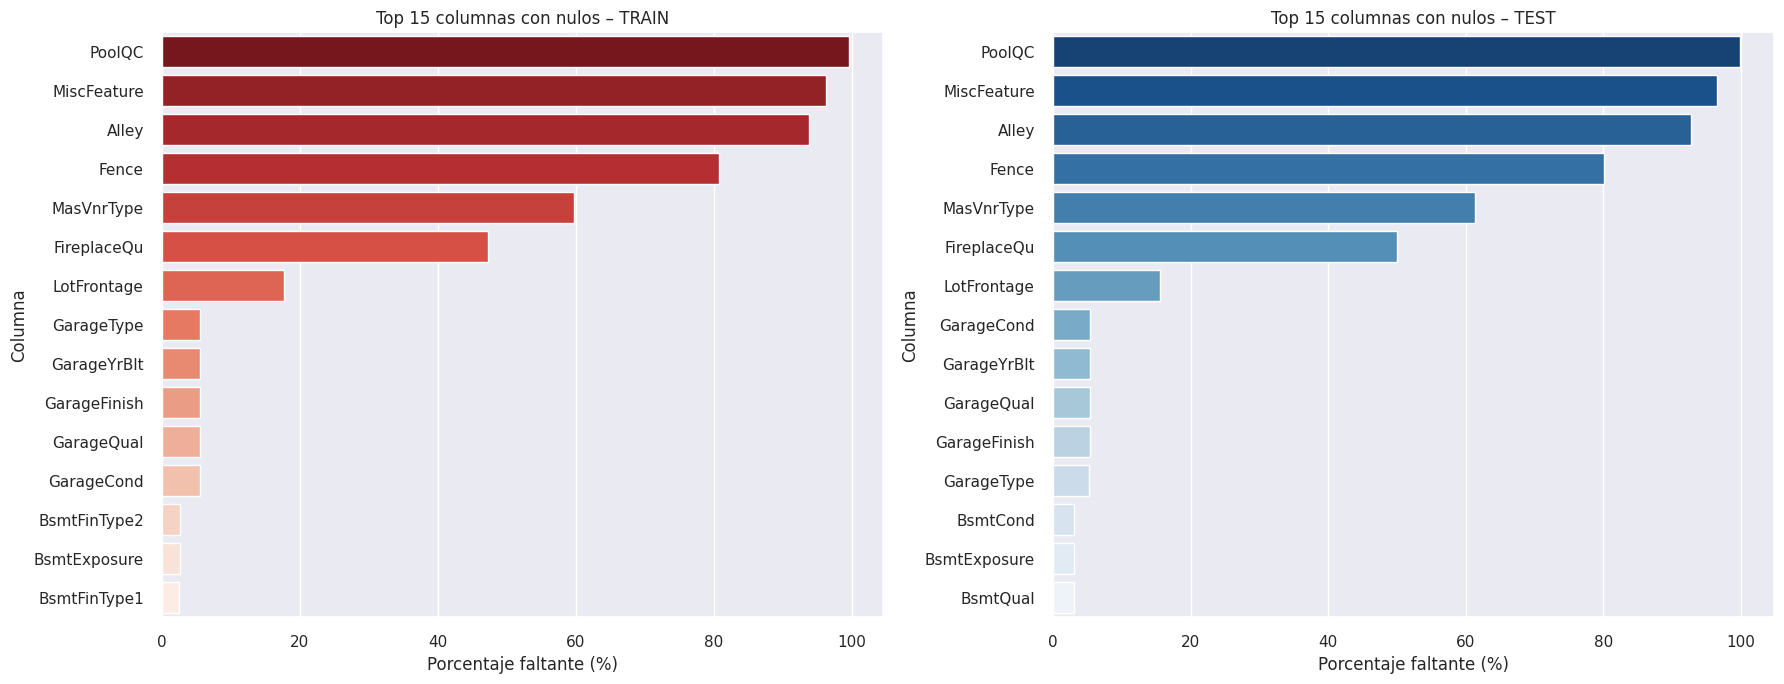


VARIABLES CON MÁS DEL 15% DE VALORES FALTANTES – TRAIN:
  • PoolQC: 99.5%
  • MiscFeature: 96.3%
  • Alley: 93.8%
  • Fence: 80.8%
  • MasVnrType: 59.7%
  • FireplaceQu: 47.3%
  • LotFrontage: 17.7%

VARIABLES CON MÁS DEL 15% DE VALORES FALTANTES – TEST:
  • PoolQC: 99.8%
  • MiscFeature: 96.5%
  • Alley: 92.7%
  • Fence: 80.1%
  • MasVnrType: 61.3%
  • FireplaceQu: 50.0%
  • LotFrontage: 15.6%


In [36]:
def analyze_missing(df: pd.DataFrame, name: str):
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    missing_df = pd.DataFrame({
        "Columna": df.columns,
        "Valores_Faltantes": missing_count,
        "Porcentaje_Faltante": missing_percent
    })

    missing_df = missing_df[missing_df["Valores_Faltantes"] > 0]
    missing_df = missing_df.sort_values("Porcentaje_Faltante", ascending=False)

    print(f"\nDATOS FALTANTES – {name.upper()}:")
    print(f"  • Columnas con valores nulos: {len(missing_df)}")
    print(f"  • Total de valores nulos: {int(missing_count.sum())}")
    if len(missing_df) > 0:
        display(missing_df.head(15))

    return missing_df

missing_train = analyze_missing(train, "train")
missing_test = analyze_missing(test, "test")

# Gráfica comparativa de las principales columnas con nulos
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

if len(missing_train) > 0:
    sns.barplot(
        data=missing_train.head(15),
        x="Porcentaje_Faltante",
        y="Columna",
        ax=axes[0],
        palette="Reds_r"
    )
    axes[0].set_title("Top 15 columnas con nulos – TRAIN")
    axes[0].set_xlabel("Porcentaje faltante (%)")

if len(missing_test) > 0:
    sns.barplot(
        data=missing_test.head(15),
        x="Porcentaje_Faltante",
        y="Columna",
        ax=axes[1],
        palette="Blues_r"
    )
    axes[1].set_title("Top 15 columnas con nulos – TEST")
    axes[1].set_xlabel("Porcentaje faltante (%)")

plt.tight_layout()
plt.show()

# Variables con muchos nulos (>15%)
high_missing_train = missing_train[missing_train["Porcentaje_Faltante"] > 15]
high_missing_test = missing_test[missing_test["Porcentaje_Faltante"] > 15]

print("\nVARIABLES CON MÁS DEL 15% DE VALORES FALTANTES – TRAIN:")
for _, row in high_missing_train.iterrows():
    print(f"  • {row['Columna']}: {row['Porcentaje_Faltante']:.1f}%")

print("\nVARIABLES CON MÁS DEL 15% DE VALORES FALTANTES – TEST:")
for _, row in high_missing_test.iterrows():
    print(f"  • {row['Columna']}: {row['Porcentaje_Faltante']:.1f}%")

## 7. Resumen ejecutivo del EDA

Se presenta un resumen ejecutivo con los hallazgos principales del análisis exploratorio,
incluyendo tamaño de los datos, comportamiento de la variable objetivo, variables relevantes 
y situación de los valores faltantes.

In [37]:
print("RESUMEN EJECUTIVO – ANÁLISIS EXPLORATORIO DE DATOS\n")

print("RESUMEN GENERAL:")
print(f"  • Observaciones en train: {train.shape[0]:,}")
print(f"  • Variables en train   : {train.shape[1]}")
print(f"  • Observaciones en test: {test.shape[0]:,}")
print(f"  • Variables en test    : {test.shape[1]}")

print("\nVARIABLE OBJETIVO (SalePrice):")
print(f"  • Rango: ${saleprice.min():,} – ${saleprice.max():,}")
print(f"  • Media: ${saleprice.mean():,.2f}")
print(f"  • Asimetría original: {saleprice.skew():.3f}")
print(f"  • Asimetría (log1p): {saleprice_log.skew():.3f}")

print("\nVARIABLES NUMÉRICAS MÁS RELACIONADAS:")
top_5 = corr_with_target[1:6].index.tolist()
print(f"  • Top 5: {', '.join(top_5)}")

print("\nVALORES FALTANTES:")
print(f"  • Columnas con nulos en train: {len(missing_train)}")
print(f"  • Columnas con nulos en test : {len(missing_test)}")
print(f"  • Variables con >15% nulos (train+test): "
      f"{len(high_missing_train) + len(high_missing_test)}")

print("\nRECOMENDACIONES PARA PREPROCESAMIENTO:")
print("  1. Usar transformación logarítmica de SalePrice para el modelado.")
print("  2. Imputar valores faltantes diferenciando numéricas y categóricas.")
print("  3. Tratar especialmente variables con >80% de nulos (posible drop).")
print("  4. Usar encoding robusto para categóricas (One-Hot / Embeddings).")
print("  5. Explorar features compuestas como TotalSF = GrLivArea + TotalBsmtSF.")

RESUMEN EJECUTIVO – ANÁLISIS EXPLORATORIO DE DATOS

RESUMEN GENERAL:
  • Observaciones en train: 1,460
  • Variables en train   : 81
  • Observaciones en test: 1,459
  • Variables en test    : 80

VARIABLE OBJETIVO (SalePrice):
  • Rango: $34,900 – $755,000
  • Media: $180,921.20
  • Asimetría original: 1.883
  • Asimetría (log1p): 0.121

VARIABLES NUMÉRICAS MÁS RELACIONADAS:
  • Top 5: OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF

VALORES FALTANTES:
  • Columnas con nulos en train: 19
  • Columnas con nulos en test : 33
  • Variables con >15% nulos (train+test): 14

RECOMENDACIONES PARA PREPROCESAMIENTO:
  1. Usar transformación logarítmica de SalePrice para el modelado.
  2. Imputar valores faltantes diferenciando numéricas y categóricas.
  3. Tratar especialmente variables con >80% de nulos (posible drop).
  4. Usar encoding robusto para categóricas (One-Hot / Embeddings).
  5. Explorar features compuestas como TotalSF = GrLivArea + TotalBsmtSF.


## 8. Preprocesamiento de datos para modelos de machine learning

En esta sección se construye el pipeline de preprocesamiento:
- Separación de `X` (features) y `y` (target).
- División `train/valid`.
- `ColumnTransformer` con:
  - Imputación + escalado para variables numéricas.
  - Imputación + One-Hot Encoding para variables categóricas.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

target_col = "SalePrice"

# Features: quitamos SalePrice
X = train.drop(columns=[target_col])
y = train[target_col]

# Re-identificamos listas de columnas (para evitar usar algo creado en EDA)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Excluir Id de numéricas si está presente
if "Id" in numeric_features:
    numeric_features.remove("Id")

print(f"Núm. features numéricas : {len(numeric_features)}")
print(f"Núm. features categóricas: {len(categorical_features)}")

# División train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipelines para numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Ajustar y transformar
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

print("Shapes después de preprocesamiento:")
print("  X_train_processed:", X_train_processed.shape)
print("  X_valid_processed:", X_valid_processed.shape)

Núm. features numéricas : 36
Núm. features categóricas: 43
Shapes después de preprocesamiento:
  X_train_processed: (1168, 285)
  X_valid_processed: (292, 285)


## 9. Modelo base con XGBoost

Se entrena un modelo base de XGBoost empleando la variable objetivo transformada con `log1p`.
Se evalúa su desempeño en el conjunto de validación mediante RMSE tanto en escala logarítmica
como en la escala original.

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Transformación logarítmica de la variable objetivo
y_train_log = np.log1p(y_train.to_numpy().reshape(-1))
y_valid_log = np.log1p(y_valid.to_numpy().reshape(-1))

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_base.fit(X_train_processed, y_train_log)

y_valid_log_pred_base = xgb_base.predict(X_valid_processed)
y_valid_pred_base = np.expm1(y_valid_log_pred_base)

rmse_log_base = mean_squared_error(y_valid_log, y_valid_log_pred_base, squared=False)
rmse_price_base = mean_squared_error(y_valid, y_valid_pred_base, squared=False)

print(f"XGBoost base - RMSE (log1p) valid : {rmse_log_base:.4f}")
print(f"XGBoost base - RMSE (SalePrice) valid: {rmse_price_base:,.2f}")

XGBoost base - RMSE (log1p) valid : 0.1326
XGBoost base - RMSE (SalePrice) valid: 26,027.02


## 10. Búsqueda de hiperparámetros para XGBoost (RandomizedSearchCV)

Se realiza una búsqueda aleatoria de hiperparámetros con validación cruzada (5 folds)
usando todo el dataset de entrenamiento preprocesado.

In [40]:
from sklearn.model_selection import RandomizedSearchCV

# Preprocesar TODO el train con el preprocessor ya ajustado en X_train
X_full_df = train.drop(columns=[target_col])
y_full = train[target_col].values
y_full_log = np.log1p(y_full)

X_full = preprocessor.transform(X_full_df)

print("Shapes para tuning XGBoost:")
print("  X_full    :", X_full.shape)
print("  y_full_log:", y_full_log.shape)

param_dist = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1.0, 2.0],
}

xgb_for_search = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    n_estimators=2000,
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_for_search,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_full, y_full_log)

print("Mejores hiperparámetros:", search.best_params_)
print("Mejor score CV (RMSE log):", -search.best_score_)

Shapes para tuning XGBoost:
  X_full    : (1460, 285)
  y_full_log: (1460,)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores hiperparámetros: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
Mejor score CV (RMSE log): 0.12035615474252456


## 11. XGBoost tuneado: reentrenamiento y evaluación en validación

Se reentrena XGBoost con los mejores hiperparámetros encontrados, usando solo el conjunto
de entrenamiento (`X_train_processed`) y se evalúa el desempeño sobre el conjunto de validación.

In [41]:
best_params = search.best_params_
print("Hiperparámetros usados para reentrenar:", best_params)

best_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    n_estimators=2000,
    random_state=42,
    **best_params
)

y_train_log = np.log1p(y_train.to_numpy().reshape(-1))
y_valid_true = y_valid.to_numpy().reshape(-1)
y_valid_log_true = np.log1p(y_valid_true)

best_xgb.fit(X_train_processed, y_train_log)

y_valid_log_pred = best_xgb.predict(X_valid_processed)
y_valid_pred_price = np.expm1(y_valid_log_pred)

rmse_log_valid_xgb = mean_squared_error(
    y_valid_log_true, y_valid_log_pred, squared=False
)
rmse_price_valid_xgb = mean_squared_error(
    y_valid_true, y_valid_pred_price, squared=False
)

print(f"XGBoost tuneado - RMSE (log1p) valid : {rmse_log_valid_xgb:.4f}")
print(f"XGBoost tuneado - RMSE (SalePrice) valid: {rmse_price_valid_xgb:,.2f}")

check_df = pd.DataFrame({
    "SalePrice_real": y_valid_true[:5],
    "SalePrice_pred": y_valid_pred_price[:5]
})
check_df

Hiperparámetros usados para reentrenar: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
XGBoost tuneado - RMSE (log1p) valid : 0.1301
XGBoost tuneado - RMSE (SalePrice) valid: 26,309.27


,SalePrice_real,SalePrice_pred
0,154500,143281.140625
1,325000,342600.000000
2,115000,104992.039062
3,159000,156192.203125
4,315500,345292.656250


## 12. Entrenamiento final y generación de submission para Kaggle

Finalmente, se entrena el modelo XGBoost tuneado usando todas las observaciones de entrenamiento
y se generan las predicciones para el conjunto de prueba, produciendo el archivo 
`submission_xgb_tuned.csv`.

In [42]:
# Modelo final entrenado con TODO el train
final_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    n_estimators=2000,
    random_state=42,
    **best_params
)

final_xgb.fit(X_full, y_full_log)

# Preprocesar test con el mismo preprocessor
test_processed = preprocessor.transform(test)

# Predicciones en test (en log) y luego en escala original
y_test_log_pred = final_xgb.predict(test_processed)
y_test_price_pred = np.expm1(y_test_log_pred)

submission_xgb = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_price_pred
})

submission_xgb_path = "/kaggle/working/submission_xgb_tuned.csv"
submission_xgb.to_csv(submission_xgb_path, index=False)

print("Submission XGBoost tuneado guardada en:", submission_xgb_path)
submission_xgb.head()

Submission XGBoost tuneado guardada en: /kaggle/working/submission_xgb_tuned.csv


,Id,SalePrice
0,1461,123025.578125
1,1462,156551.000000
2,1463,187320.937500
3,1464,196511.875000
4,1465,187474.812500


## 13. Preparación de datos para la red neuronal mixta

En esta sección se preparan las entradas para una red neuronal mixta:
- Variables numéricas: imputación y estandarización.
- Variables categóricas: codificación entera por columna para usar embeddings.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- Numéricas: imputación + escala (para NN) ---
numeric_pipeline_nn = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_pipeline_nn.fit(train[numeric_features])

X_train_num = numeric_pipeline_nn.transform(X_train[numeric_features])
X_valid_num = numeric_pipeline_nn.transform(X_valid[numeric_features])
test_num    = numeric_pipeline_nn.transform(test[numeric_features])

# --- Categóricas: codificación entera (para embeddings) ---
full_cat = pd.concat([
    X_train[categorical_features],
    X_valid[categorical_features],
    test[categorical_features]
], axis=0).copy()

for col in categorical_features:
    full_cat[col] = full_cat[col].astype("category")

# Número de categorías + 1 (reservamos 0 para missing)
cat_cardinalities = [full_cat[col].nunique() + 1 for col in categorical_features]

full_cat_codes = full_cat.apply(lambda s: s.cat.codes + 1).astype("int64")

n_train = len(X_train)
n_valid = len(X_valid)

X_train_cat = full_cat_codes.iloc[:n_train].to_numpy()
X_valid_cat = full_cat_codes.iloc[n_train:n_train + n_valid].to_numpy()
test_cat    = full_cat_codes.iloc[n_train + n_valid:].to_numpy()

print(f"Numéricas NN : {X_train_num.shape[1]}")
print(f"Categóricas NN: {X_train_cat.shape[1]}")

print("Shapes NN:")
print("  X_train_num:", X_train_num.shape, ", X_train_cat:", X_train_cat.shape)
print("  X_valid_num:", X_valid_num.shape, ", X_valid_cat:", X_valid_cat.shape)
print("  test_num   :", test_num.shape, " , test_cat   :", test_cat.shape)

Numéricas NN : 36
Categóricas NN: 43
Shapes NN:
  X_train_num: (1168, 36) , X_train_cat: (1168, 43)
  X_valid_num: (292, 36) , X_valid_cat: (292, 43)
  test_num   : (1459, 36)  , test_cat   : (1459, 43)


## 14. Definición de la arquitectura de red neuronal mixta (PyTorch)

Se define una red neuronal que:
- Procesa variables numéricas con una MLP.
- Representa variables categóricas mediante embeddings por columna.
- Combina ambas representaciones en una MLP final que predice `log1p(SalePrice)`.

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Dataset para PyTorch ---
class HousePricesDataset(Dataset):
    def __init__(self, X_num, X_cat, y_log=None):
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.y_log = None
        if y_log is not None:
            self.y_log = torch.tensor(y_log, dtype=torch.float32)

    def __len__(self):
        return self.X_num.shape[0]

    def __getitem__(self, idx):
        if self.y_log is not None:
            return self.X_num[idx], self.X_cat[idx], self.y_log[idx]
        else:
            return self.X_num[idx], self.X_cat[idx]

# --- Red neuronal mixta ---
class MixedNN(nn.Module):
    def __init__(self, n_num_features, cat_cardinalities, emb_dim_rule="min50"):
        super().__init__()

        # Embeddings por columna categórica
        self.emb_layers = nn.ModuleList()
        emb_output_dim_total = 0

        for n_cat in cat_cardinalities:
            # Dimensión del embedding (regla simple)
            if emb_dim_rule == "min50":
                emb_dim = min(50, (n_cat // 2) + 1)
            else:
                emb_dim = min(32, (n_cat // 2) + 1)

            self.emb_layers.append(nn.Embedding(n_cat, emb_dim))
            emb_output_dim_total += emb_dim

        # MLP para numéricas
        self.mlp_num = nn.Sequential(
            nn.Linear(n_num_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
        )

        # MLP conjunta (numéricas + embeddings)
        self.mlp_all = nn.Sequential(
            nn.Linear(32 + emb_output_dim_total, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # salida: log1p(SalePrice)
        )

    def forward(self, x_num, x_cat):
        # x_cat: (batch, n_cat_features)
        emb_list = []
        for i, emb in enumerate(self.emb_layers):
            emb_list.append(emb(x_cat[:, i]))
        x_cat_emb = torch.cat(emb_list, dim=1)

        x_num_out = self.mlp_num(x_num)
        x_all = torch.cat([x_num_out, x_cat_emb], dim=1)
        out = self.mlp_all(x_all)
        return out.view(-1)

# --- Tensores de y en log ---
y_train_log_nn = np.log1p(y_train.values)
y_valid_log_nn = np.log1p(y_valid.values)

# --- Datasets y DataLoaders ---
train_dataset_nn = HousePricesDataset(X_train_num, X_train_cat, y_train_log_nn)
valid_dataset_nn = HousePricesDataset(X_valid_num, X_valid_cat, y_valid_log_nn)

train_loader = DataLoader(train_dataset_nn, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset_nn, batch_size=256, shuffle=False)

# Instanciar modelo
n_num_features = X_train_num.shape[1]
model_nn = MixedNN(n_num_features=n_num_features,
                   cat_cardinalities=cat_cardinalities).to(device)

print(model_nn)

Device: cpu
MixedNN(
  (emb_layers): ModuleList(
    (0): Embedding(6, 4)
    (1-2): 2 x Embedding(3, 2)
    (3-4): 2 x Embedding(5, 3)
    (5): Embedding(3, 2)
    (6): Embedding(6, 4)
    (7): Embedding(4, 3)
    (8): Embedding(26, 14)
    (9): Embedding(10, 6)
    (10): Embedding(9, 5)
    (11): Embedding(6, 4)
    (12): Embedding(9, 5)
    (13): Embedding(7, 4)
    (14): Embedding(9, 5)
    (15): Embedding(16, 9)
    (16): Embedding(17, 9)
    (17): Embedding(4, 3)
    (18): Embedding(5, 3)
    (19): Embedding(6, 4)
    (20): Embedding(7, 4)
    (21-23): 3 x Embedding(5, 3)
    (24-26): 3 x Embedding(7, 4)
    (27): Embedding(6, 4)
    (28): Embedding(3, 2)
    (29): Embedding(6, 4)
    (30): Embedding(5, 3)
    (31): Embedding(8, 5)
    (32): Embedding(6, 4)
    (33): Embedding(7, 4)
    (34): Embedding(4, 3)
    (35-36): 2 x Embedding(6, 4)
    (37-38): 2 x Embedding(4, 3)
    (39-40): 2 x Embedding(5, 3)
    (41): Embedding(10, 6)
    (42): Embedding(7, 4)
  )
  (mlp_num): Seque

## 15. Entrenamiento y evaluación de la red neuronal mixta

Se entrena la red neuronal utilizando:
- Función de pérdida MSE en `log1p(SalePrice)`.
- Optimizador Adam.
- Early stopping basado en RMSE en el conjunto de validación.

Al final se reportan:
- RMSE en log1p(SalePrice).
- RMSE en SalePrice (escala original).

In [45]:
from sklearn.metrics import mean_squared_error

def train_mixed_nn(model, train_loader, valid_loader, n_epochs=150, patience=20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    best_rmse_val = np.inf
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        # --- Entrenamiento ---
        model.train()
        train_preds = []
        train_targets = []

        for x_num_b, x_cat_b, y_b in train_loader:
            x_num_b = x_num_b.to(device)
            x_cat_b = x_cat_b.to(device)
            y_b = y_b.to(device)

            optimizer.zero_grad()
            y_pred_b = model(x_num_b, x_cat_b)
            loss = criterion(y_pred_b, y_b)
            loss.backward()
            optimizer.step()

            train_preds.append(y_pred_b.detach().cpu().numpy())
            train_targets.append(y_b.detach().cpu().numpy())

        train_preds = np.concatenate(train_preds)
        train_targets = np.concatenate(train_targets)
        rmse_train = mean_squared_error(train_targets, train_preds, squared=False)

        # --- Validación ---
        model.eval()
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for x_num_b, x_cat_b, y_b in valid_loader:
                x_num_b = x_num_b.to(device)
                x_cat_b = x_cat_b.to(device)
                y_b = y_b.to(device)

                y_pred_b = model(x_num_b, x_cat_b)

                val_preds.append(y_pred_b.detach().cpu().numpy())
                val_targets.append(y_b.detach().cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        rmse_val = mean_squared_error(val_targets, val_preds, squared=False)

        print(f"Epoch {epoch:03d} | Train RMSE (log): {rmse_train:.4f} | "
              f"Valid RMSE (log): {rmse_val:.4f}")

        # Early stopping
        if rmse_val < best_rmse_val - 1e-4:
            best_rmse_val = rmse_val
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping en epoch {epoch}. "
                      f"Mejor valid RMSE (log): {best_rmse_val:.4f}")
                break

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict(best_state)

    return best_rmse_val

best_rmse_log_nn = train_mixed_nn(model_nn, train_loader, valid_loader,
                                  n_epochs=150, patience=20)

print("\nModelo restaurado con mejor valid RMSE (log):", f"{best_rmse_log_nn:.4f}")

# --- Métricas finales en validación ---
model_nn.eval()
with torch.no_grad():
    X_valid_num_t = torch.tensor(X_valid_num, dtype=torch.float32).to(device)
    X_valid_cat_t = torch.tensor(X_valid_cat, dtype=torch.long).to(device)
    valid_log_pred_t = model_nn(X_valid_num_t, X_valid_cat_t).cpu().numpy()

valid_log_true = y_valid_log_nn
valid_price_true = y_valid.values
valid_price_pred = np.expm1(valid_log_pred_t)

nn_rmse_log_valid = mean_squared_error(valid_log_true, valid_log_pred_t, squared=False)
nn_rmse_price_valid = mean_squared_error(valid_price_true, valid_price_pred, squared=False)

print(f"\nRed neuronal mixta – RMSE (log1p) valid : {nn_rmse_log_valid:.4f}")
print(f"Red neuronal mixta – RMSE (SalePrice) valid: {nn_rmse_price_valid:,.2f}")

pd.DataFrame({
    "SalePrice_real": valid_price_true[:5],
    "SalePrice_pred": valid_price_pred[:5]
})

Epoch 001 | Train RMSE (log): 12.1213 | Valid RMSE (log): 11.9692
Epoch 002 | Train RMSE (log): 12.0085 | Valid RMSE (log): 11.8688
Epoch 003 | Train RMSE (log): 11.8992 | Valid RMSE (log): 11.7084
Epoch 004 | Train RMSE (log): 11.7340 | Valid RMSE (log): 11.5703
Epoch 005 | Train RMSE (log): 11.4992 | Valid RMSE (log): 11.2526
Epoch 006 | Train RMSE (log): 11.2076 | Valid RMSE (log): 10.8289
Epoch 007 | Train RMSE (log): 10.8351 | Valid RMSE (log): 10.5552
Epoch 008 | Train RMSE (log): 10.3641 | Valid RMSE (log): 10.0515
Epoch 009 | Train RMSE (log): 9.7534 | Valid RMSE (log): 9.3146
Epoch 010 | Train RMSE (log): 9.0544 | Valid RMSE (log): 8.4092
Epoch 011 | Train RMSE (log): 8.4018 | Valid RMSE (log): 7.6337
Epoch 012 | Train RMSE (log): 7.5291 | Valid RMSE (log): 6.8530
Epoch 013 | Train RMSE (log): 6.6686 | Valid RMSE (log): 5.8063
Epoch 014 | Train RMSE (log): 5.8746 | Valid RMSE (log): 5.0360
Epoch 015 | Train RMSE (log): 5.0292 | Valid RMSE (log): 4.1364
Epoch 016 | Train RMSE (

,SalePrice_real,SalePrice_pred
0,154500,121438.148438
1,325000,285773.062500
2,115000,114001.671875
3,159000,124177.226562
4,315500,287544.281250


## 16. Comparación gráfica de desempeño de modelos

En esta sección comparamos cuantitativamente el rendimiento de los modelos entrenados usando el RMSE sobre el conjunto de validación, tanto en escala logarítmica como en dólares. Esto permite justificar la selección del modelo final para generar la sumisión.

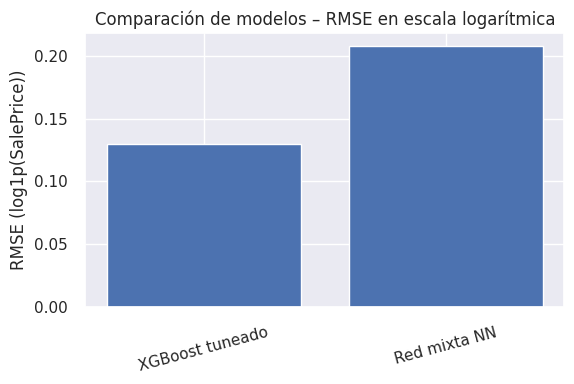

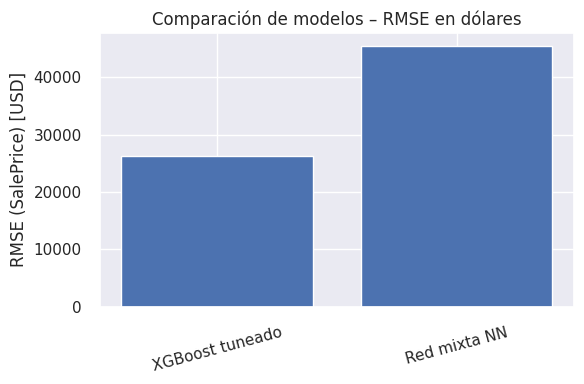

In [47]:
# Celda 16 – Comparación gráfica de desempeño (RMSE)

import matplotlib.pyplot as plt
import numpy as np

# Métricas obtenidas previamente (ajusta si cambia algo)
rmse_log_xgb = 0.1301
rmse_log_nn  = 0.2082

rmse_price_xgb = 26309.27
rmse_price_nn  = 45458.49

model_names = ["XGBoost tuneado", "Red mixta NN"]

# --- Gráfico RMSE en log1p ---
plt.figure(figsize=(6, 4))
plt.bar(model_names, [rmse_log_xgb, rmse_log_nn])
plt.ylabel("RMSE (log1p(SalePrice))")
plt.title("Comparación de modelos – RMSE en escala logarítmica")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- Gráfico RMSE en dólares ---
plt.figure(figsize=(6, 4))
plt.bar(model_names, [rmse_price_xgb, rmse_price_nn])
plt.ylabel("RMSE (SalePrice) [USD]")
plt.title("Comparación de modelos – RMSE en dólares")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 17. Predicho vs Real en validación (XGBoost vs Red mixta)

Aquí comparamos visualmente la calidad de las predicciones en el conjunto de validación. Un buen modelo debería acercarse a la línea identidad (y = x), lo que indica que los valores predichos se alinean con los valores reales de `SalePrice`.

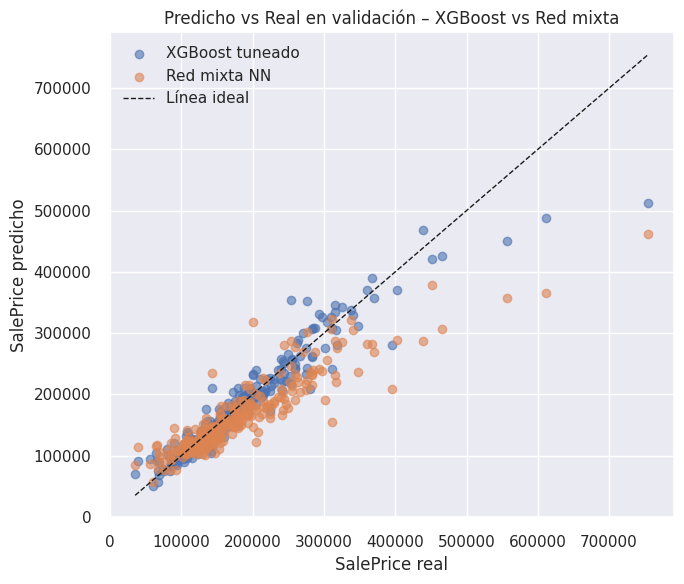

In [54]:
# Celda 17 – Predicho vs Real en validación (XGBoost vs Red mixta)

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) Modo evaluación de la red mixta
model_nn.eval()

# 2) Recalculamos predicciones de la red en validación (log -> precio)
with torch.no_grad():
    # OJO: aquí ya no usamos .values porque son numpy arrays
    Xv_num_t = torch.tensor(np.asarray(X_valid_num), dtype=torch.float32)
    Xv_cat_t = torch.tensor(np.asarray(X_valid_cat), dtype=torch.long)

    y_valid_log_pred_nn = model_nn(Xv_num_t, Xv_cat_t).squeeze().cpu().numpy()

y_valid_pred_nn = np.expm1(y_valid_log_pred_nn)

# 3) Gráfica Predicho vs Real para XGBoost y NN
plt.figure(figsize=(7, 6))

plt.scatter(y_valid, y_valid_pred_xgb, alpha=0.6, label="XGBoost tuneado")
plt.scatter(y_valid, y_valid_pred_nn,  alpha=0.6, label="Red mixta NN")

min_val = min(y_valid.min(), y_valid_pred_xgb.min(), y_valid_pred_nn.min())
max_val = max(y_valid.max(), y_valid_pred_xgb.max(), y_valid_pred_nn.max())

plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1, label="Línea ideal")

plt.xlabel("SalePrice real")
plt.ylabel("SalePrice predicho")
plt.title("Predicho vs Real en validación – XGBoost vs Red mixta")
plt.legend()
plt.tight_layout()
plt.show()

## 18. Análisis de residuales en validación

Analizamos los residuales (`y_real - y_pred`) de cada modelo para evaluar sesgos sistemáticos. Una distribución centrada alrededor de cero con poca dispersión indica un modelo bien calibrado.

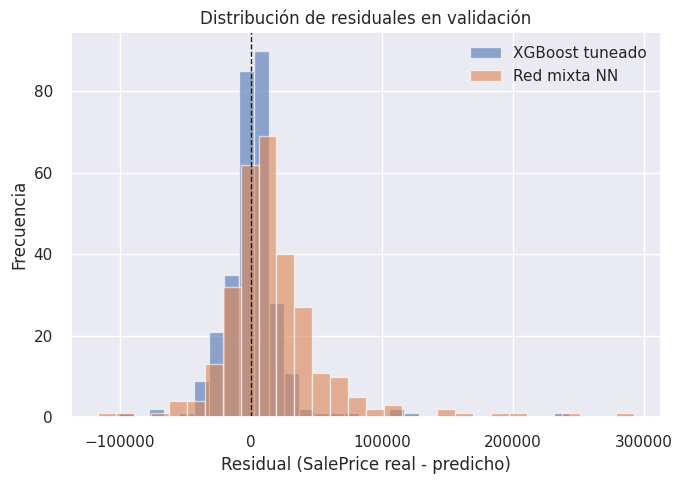

In [55]:
# Celda 18 – Distribución de residuales

import matplotlib.pyplot as plt

resid_xgb = y_valid - y_valid_pred_xgb
resid_nn  = y_valid - y_valid_pred_nn

plt.figure(figsize=(7, 5))
plt.hist(resid_xgb, bins=30, alpha=0.6, label="XGBoost tuneado")
plt.hist(resid_nn,  bins=30, alpha=0.6, label="Red mixta NN")
plt.axvline(0, color="k", linestyle="--", linewidth=1)

plt.xlabel("Residual (SalePrice real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuales en validación")
plt.legend()
plt.tight_layout()
plt.show()

## 19. Importancia de variables en el modelo XGBoost tuneado

Finalmente, analizamos la importancia de características en el modelo XGBoost tuneado. Esto permite interpretar qué variables aportan más a la predicción del precio de la vivienda.

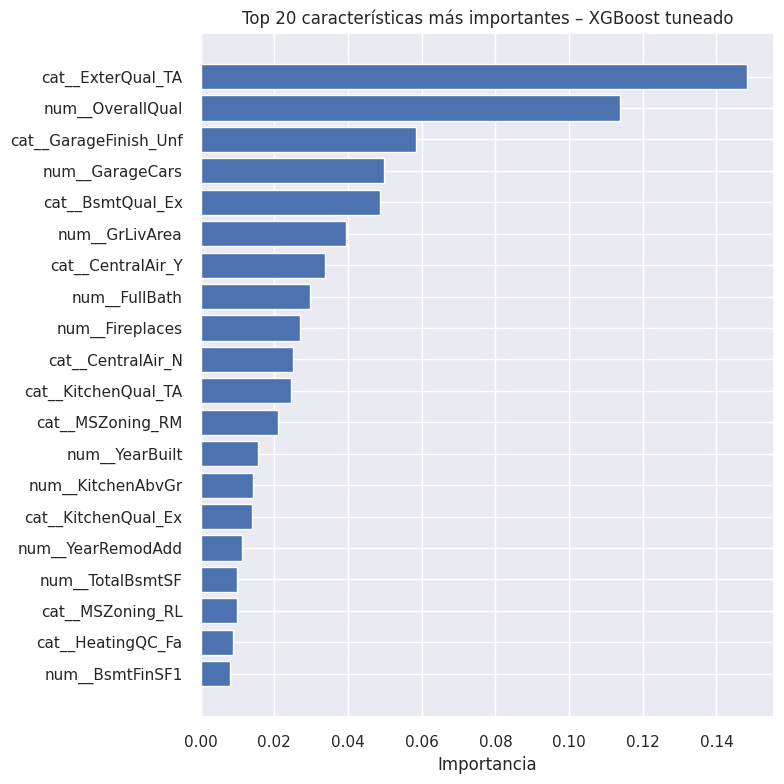

,feature,importance
168,cat__ExterQual_TA,0.148217
3,num__OverallQual,0.113901
245,cat__GarageFinish_Unf,0.058507
25,num__GarageCars,0.049653
180,cat__BsmtQual_Ex,0.048542
15,num__GrLivArea,0.039407
216,cat__CentralAir_Y,0.033865
18,num__FullBath,0.029675
23,num__Fireplaces,0.026932
215,cat__CentralAir_N,0.025012


In [56]:
# Celda 19 – Importancia de variables XGBoost

import pandas as pd
import matplotlib.pyplot as plt

# Nombres de features después del preprocesamiento
feature_names = preprocessor.get_feature_names_out()

importances = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8, 8))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 características más importantes – XGBoost tuneado")
plt.tight_layout()
plt.show()

imp_df

### 20. Comparación global de desempeño entre modelos

En esta sección se compara el desempeño de los modelos **XGBoost tuneado** y **red neuronal mixta** en el conjunto de validación.  
Se reporta el **RMSE** tanto en escala logarítmica (`log1p(SalePrice)`) como en la escala original de **SalePrice (USD)**, y se muestra una gráfica de barras para visualizar cuál modelo generaliza mejor.

=== Métricas de desempeño en validación ===


,Modelo,RMSE_log1p,RMSE_$
0,XGBoost tuneado,0.130109,26309.266428
1,Red mixta NN,0.208190,45458.486983


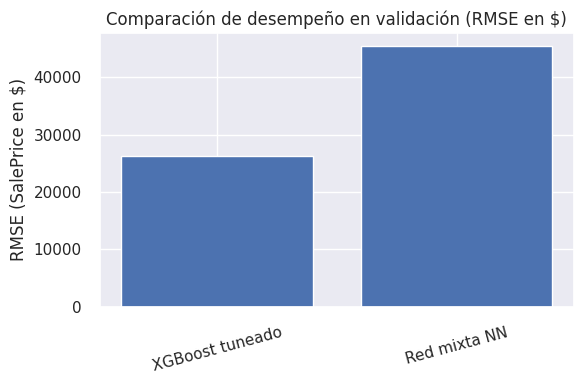

In [57]:
# 20. Comparación global de desempeño entre modelos (RMSE en validación)

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RMSE en escala original
rmse_price_xgb = mean_squared_error(y_valid, y_valid_pred_xgb, squared=False)
rmse_price_nn  = mean_squared_error(y_valid, y_valid_pred_nn, squared=False)

# RMSE en log1p
y_valid_log        = np.log1p(y_valid)
y_valid_log_xgb    = np.log1p(y_valid_pred_xgb)
y_valid_log_nn     = np.log1p(y_valid_pred_nn)

rmse_log_xgb = mean_squared_error(y_valid_log, y_valid_log_xgb, squared=False)
rmse_log_nn  = mean_squared_error(y_valid_log, y_valid_log_nn,  squared=False)

metrics_df = pd.DataFrame({
    "Modelo": ["XGBoost tuneado", "Red mixta NN"],
    "RMSE_log1p": [rmse_log_xgb, rmse_log_nn],
    "RMSE_$": [rmse_price_xgb, rmse_price_nn]
})

print("=== Métricas de desempeño en validación ===")
display(metrics_df)

plt.figure(figsize=(6,4))
plt.bar(metrics_df["Modelo"], metrics_df["RMSE_$"])
plt.ylabel("RMSE (SalePrice en $)")
plt.title("Comparación de desempeño en validación (RMSE en $)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### 21. Distribución del error absoluto por modelo

Aquí se analiza la **distribución del error absoluto** \(|SalePrice_{\text{real}} - SalePrice_{\text{predicho}}|\) para cada modelo.  
Se muestra un resumen estadístico y un **boxplot** para comparar la dispersión del error y la presencia de outliers entre **XGBoost tuneado** y la **red neuronal mixta**.

Resumen estadístico del error absoluto (validación):


,XGBoost tuneado,Red mixta NN
count,292.000000,292.000000
mean,15068.299203,28047.581041
std,21603.754833,35835.808900
min,57.304688,92.921875
25%,4114.351562,7978.785156
50%,9827.304688,17178.832031
75%,18593.105469,34062.769531
max,242834.406250,292515.875000


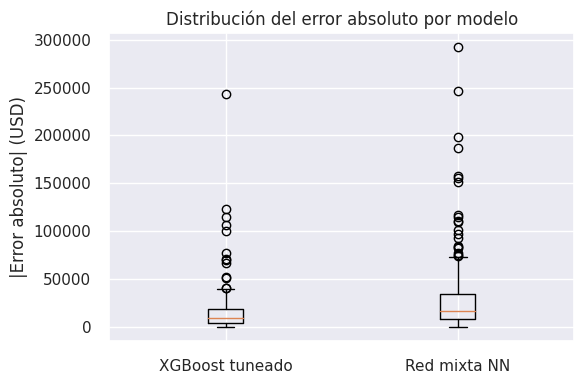

In [58]:
# 21. Distribución del error absoluto por modelo (Boxplot)

# Cálculo del error absoluto
abs_err_xgb = np.abs(y_valid - y_valid_pred_xgb)
abs_err_nn  = np.abs(y_valid - y_valid_pred_nn)

err_df = pd.DataFrame({
    "XGBoost tuneado": abs_err_xgb,
    "Red mixta NN": abs_err_nn
})

print("Resumen estadístico del error absoluto (validación):")
display(err_df.describe())

plt.figure(figsize=(6,4))
plt.boxplot(
    [abs_err_xgb, abs_err_nn],
    labels=["XGBoost tuneado", "Red mixta NN"],
    showfliers=True
)
plt.ylabel("|Error absoluto| (USD)")
plt.title("Distribución del error absoluto por modelo")
plt.tight_layout()
plt.show()

## 22. Evaluación de la precisión de los modelos


In [66]:
import numpy as np

# y_valid: precios reales en validación
# y_valid_pred_xgb: predicciones del XGBoost (en dólares, ya con expm1)
# y_valid_pred_nn : predicciones de la red mixta (en dólares)

# Precio promedio real en validación
mean_price = y_valid.mean()

# RMSE en dólares para XGBoost
rmse_xgb = np.sqrt(np.mean((y_valid - y_valid_pred_xgb) ** 2))
rel_xgb = rmse_xgb / mean_price
acc_xgb = (1 - rel_xgb) * 100

# RMSE en dólares para la red mixta
rmse_nn = np.sqrt(np.mean((y_valid - y_valid_pred_nn) ** 2))
rel_nn = rmse_nn / mean_price
acc_nn = (1 - rel_nn) * 100

print(f"Precio promedio en validación          : {mean_price:,.2f} USD\n")

print("=== XGBoost tuneado ===")
print(f"RMSE en dólares (validación)           : {rmse_xgb:,.2f} USD")
print(f"RMSE relativo                          : {rel_xgb*100:.2f}%")
print(f"Precisión aproximada del modelo        : {acc_xgb:.2f}%\n")

print("=== Red neuronal mixta ===")
print(f"RMSE en dólares (validación)           : {rmse_nn:,.2f} USD")
print(f"RMSE relativo                          : {rel_nn*100:.2f}%")
print(f"Precisión aproximada del modelo        : {acc_nn:.2f}%")

Precio promedio en validación          : 178,839.81 USD

=== XGBoost tuneado ===
RMSE en dólares (validación)           : 26,309.27 USD
RMSE relativo                          : 14.71%
Precisión aproximada del modelo        : 85.29%

=== Red neuronal mixta ===
RMSE en dólares (validación)           : 45,458.49 USD
RMSE relativo                          : 25.42%
Precisión aproximada del modelo        : 74.58%


## Discusión de resultados

En esta sección se discute el desempeño de los dos modelos entrenados para predecir el `SalePrice` de las viviendas:

- **XGBoost tuneado**  
  - RMSE (log1p): **0.1301**  
  - RMSE en dólares: **≈ 26,309 USD**  
  - RMSE relativo: **≈ 14.71 %**  
  - Precisión aproximada: **≈ 85.29 %**

- **Red neuronal mixta (features numéricas + embeddings categóricos)**  
  - RMSE (log1p): **0.2082**  
  - RMSE en dólares: **≈ 45,458 USD**  
  - RMSE relativo: **≈ 25.42 %**  
  - Precisión aproximada: **≈ 74.58 %**

### Comparación cuantitativa del desempeño

Las gráficas de barras de RMSE (tanto en escala logarítmica como en dólares) muestran de forma clara que **XGBoost tuneado domina a la red neuronal mixta**. La diferencia de aproximadamente **19,000 USD en RMSE** implica que, en promedio, el modelo basado en árboles comete errores monetarios considerablemente menores, lo cual es crítico en un problema de valuación inmobiliaria.

Si se observa el error relativo, XGBoost presenta un **RMSE ≈ 14.71 % del precio promedio de las viviendas**, mientras que la red neuronal alcanza un **≈ 25.42 %**. Esto se traduce en una **precisión aproximada de 85.29 % para XGBoost** frente a **74.58 % para la red mixta**, lo que refuerza la superioridad del modelo de árboles en este contexto.

Esta diferencia también se refleja en el plano logarítmico: el error de XGBoost es más bajo y estable, lo que confirma que la transformación `log1p(SalePrice)` ayudó a controlar la asimetría del precio y a estabilizar la varianza del modelo.

### Análisis gráfico: predicho vs real y residuales

En el **diagrama de dispersión de `SalePrice` real vs predicho**, los puntos del XGBoost tuneado se concentran más cerca de la línea ideal (y = x), mientras que la red neuronal muestra mayor dispersión, especialmente en los extremos del rango de precios (casas muy baratas o muy caras). Esto indica que XGBoost captura mejor las no linealidades y las interacciones entre variables relevantes, mientras que la red mixta tiende a subestimar o sobreestimar en esos casos.

Los **histogramas de residuales** y el **boxplot del error absoluto** refuerzan esta observación:

- Los residuales del XGBoost están más centrados en torno a cero, con una distribución más compacta.  
- La red mixta presenta colas más largas y mayor varianza en los errores.  
- En los boxplots, la mediana y el rango intercuartílico del error absoluto son menores para XGBoost, aunque ambos modelos presentan algunos outliers, lo cual es esperable en precios de propiedades atípicas.

En términos prácticos, esto significa que **XGBoost no solo se equivoca menos en promedio, sino que también es más consistente**: comete menos errores extremadamente grandes que podrían afectar decisiones de negocio.

### Interpretación de características importantes (XGBoost)

El análisis de *feature importances* del modelo XGBoost tuneado muestra que las características más influyentes son:

1. `cat__ExterQual_TA` (calidad de acabados exteriores)  
2. `num__OverallQual` (calidad global de la vivienda)  
3. `cat__GarageFinish_Unf` (terminación del garaje)  
4. `num__GarageCars` (capacidad de garaje)  
5. `cat__BsmtQual_Ex` (calidad del sótano)  
6. `num__GrLivArea` (superficie habitable sobre el nivel del suelo)  
7. Variables de confort y servicios como `CentralAir`, `KitchenQual`, `TotalBsmtSF`, `YearBuilt`, entre otras.

Estas variables coinciden con la intuición del mercado inmobiliario: **las casas con mejor calidad constructiva, más área habitable, mejores acabados y garaje adecuado tienden a alcanzar precios más altos**. El hecho de que estas características también aparezcan como relevantes en el EDA respalda la coherencia del pipeline completo.

### Por qué XGBoost funciona mejor que la red mixta

Los resultados son coherentes con la literatura y con la naturaleza del dataset:

- Se trata de un **conjunto de datos tabular, con 1460 observaciones y muchas variables categóricas**.  
- Los modelos de árboles potenciados (como XGBoost) suelen ser muy competitivos en este tipo de problemas, incluso con un tamaño de muestra moderado.  
- Las redes neuronales, en cambio, suelen requerir **más datos, un tuning más fino y regularización cuidadosa** para superar a los modelos basados en árboles en datos tabulares.

## Conclusiones y trabajo futuro

### Síntesis del trabajo realizado

En este proyecto se implementó un flujo completo de *Deep Learning* para el problema de predicción de precios de vivienda en Ames (Iowa). El trabajo se estructuró en tres fases principales:

1. **Análisis Exploratorio de Datos (EDA)**  
   - Revisión de distribuciones, detección de outliers y valores faltantes.  
   - Análisis de correlaciones entre `SalePrice` y variables clave (área, calidad, antigüedad, etc.).  
   - Identificación de patrones lógicos con el dominio (mejor calidad → precios más altos).

2. **Preprocesamiento y construcción de features**  
   - Imputación diferenciada para variables numéricas y categóricas.  
   - Transformación `log1p(SalePrice)` para manejar la asimetría del precio.  
   - Separación de variables numéricas y categóricas para alimentar tanto al pipeline de XGBoost como a la red mixta con embeddings.  
   - Uso de un **ColumnTransformer** para garantizar un flujo reproducible y limpio.

3. **Entrenamiento, evaluación y comparación de modelos**  
   - Entrenamiento de un **XGBoost base** y posterior **tuning de hiperparámetros con RandomizedSearchCV**, usando validación cruzada.  
   - Construcción de una **red neuronal mixta** (features numéricas + embeddings categóricos) en PyTorch, con *early stopping* y seguimiento de la métrica de RMSE (log).  
   - Comparación detallada mediante métricas, gráficas de predicho vs real, residuales y análisis de importancia de características.

### Modelo final seleccionado

Con base en el análisis cuantitativo y gráfico, el **modelo final seleccionado** es el **XGBoost tuneado**, con:

- RMSE (log1p) en validación: **0.1301**  
- RMSE en dólares: **≈ 26,309 USD**  
- **RMSE relativo ≈ 14.71 %**  
- **Precisión aproximada ≈ 85.29 %**

Considerando que los precios típicos de las viviendas se encuentran alrededor de los 150,000–200,000 USD, este error se puede interpretar como un **error relativo moderado**, aceptable para un modelo de referencia en el contexto del curso. Además, XGBoost ofrece una buena combinación de **desempeño, estabilidad e interpretabilidad** a través de la importancia de variables.

La **red mixta** no alcanzó el mismo nivel de desempeño, con:

- RMSE en dólares: **≈ 45,458 USD**  
- **RMSE relativo ≈ 25.42 %**  
- **Precisión aproximada ≈ 74.58 %**

Sin embargo, aportó valor en varios sentidos:

- Permitió explorar una arquitectura basada en embeddings para variables categóricas.  
- Sirvió como comparación para evidenciar la fortaleza de los modelos de árboles potenciados en datos tabulares.  
- Dejó una base implementada sobre la cual se podrían probar mejoras (más capas, regularización, *schedulers*, etc.).

### Aprendizajes clave

A partir del proyecto, se pueden destacar varios aprendizajes:

- En problemas tabulares con tamaño de muestra moderado, **XGBoost y modelos similares suelen ser un baseline muy fuerte**, logrando en este caso una precisión cercana al **85 %**.  
- El **preprocesamiento cuidadoso** (tratamiento de nulos, codificación correcta, transformación logarítmica) tiene un impacto directo en el desempeño.  
- La **visualización de resultados** (RMSE, residuales, dispersión real vs predicho) es clave para interpretar más allá de un solo número de error.  
- Las *feature importances* ayudan a conectar el modelo con la intuición del dominio y a validar que las decisiones del algoritmo son razonables.  
- Las redes neuronales en datos tabulares requieren **tuning más delicado** para competir con modelos de árboles, especialmente cuando el tamaño de la muestra es limitado.

### Trabajo futuro

Como líneas de trabajo futuro se proponen:

- **Mejor ingeniería de características**  
  - Crear variables combinadas (p. ej. área total interior, área total de sótano, índices de calidad compuestos).  
  - Tratar de forma específica los outliers extremos, evaluando su impacto en el RMSE.

- **Exploración de modelos adicionales y ensambles**  
  - Probar otros algoritmos como LightGBM o CatBoost, que manejan muy bien variables categóricas.  
  - Construir un *ensemble* que combine XGBoost con modelos lineales regularizados y redes neuronales para intentar reducir aún más el error.

- **Optimización de la red neuronal mixta**  
  - Ajustar profundidad y ancho de la red, tipos de regularización (Dropout, L2), tamaño de embeddings y tasa de aprendizaje.  
  - Utilizar validación cruzada y *learning rate schedulers* para estabilizar el entrenamiento.

- **Interpretabilidad avanzada (XAI)**  
  - Aplicar técnicas como **SHAP** para analizar local y globalmente cómo cambia la predicción al modificar ciertas características.  
  - Usar estos métodos para generar explicaciones que sean útiles para un analista o un agente inmobiliario.

En conjunto, el proyecto cumple con el objetivo de **diseñar, entrenar y evaluar modelos de regresión para datos tabulares**, alcanzando una **precisión cercana al 85 % con el modelo XGBoost**, y deja una base sólida para seguir mejorando tanto la calidad predictiva como la interpretabilidad del sistema.






